# Введение

Набор данных ASHRAE содержит информацию о потреблении энергии примерно 2000 зданий из 16 городов за период в календарный год. Дополнительно есть данные о погодных условиях в этот год.

**Задача**: предсказать потребление энергии для этих зданий на полтора года вперёд с учетом известных метеорологических показателей (известной погоды).

Для решения задачи будет использована линейная регрессия.

In [73]:
# analysis
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
## params for visualization
rcParams['figure.figsize'] = (16, 8)
sns.set_style("darkgrid")
sns.set_palette("viridis")

## ETL - Extract Transform Load
Процесс ETL подразумевает получение, очистку, объединение данных для дальнейшей работы (анализа, обучения моделей)

#### Загрузка данных

In [2]:
building_data = pd.read_csv('data/building_metadata.csv.gz')
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


Описание данных о **зданиях**:
- `primary_use` - назначение здания
- `square_feet` - площадь в квадратных футах
- `year_built` - дата построения
- `floor_count` - число этажей

In [3]:
weather_data = pd.read_csv('data/weather_train.csv.gz')
weather_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [7]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


Описание данных о **погоде**:
- `timestamp` - дата измерения
- `air_temperature` - температура воздуха (в градусах Цельсия, С)
- `cloud_coverage` - облачность (в процентах, %)
- `dew_temperature` - влажность/точка росы (в градусах Цельсия, С)
- `precip_depth_1_hr` - количество осадков (мм/час)
- `sea_level_pressure` - давление (миллибар)
- `wind_direction` - направление ветра (градусы)
- `wind_speed` - скорость ветра (м/с)

In [8]:
energy_build0_data = pd.read_csv('data/train.0.0.csv.gz')
energy_build0_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,0,0,2016-01-01 01:00:00,0.0
2,0,0,2016-01-01 02:00:00,0.0
3,0,0,2016-01-01 03:00:00,0.0
4,0,0,2016-01-01 04:00:00,0.0


In [9]:
energy_build0_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   building_id    8784 non-null   int64  
 1   meter          8784 non-null   int64  
 2   timestamp      8784 non-null   object 
 3   meter_reading  8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [5]:
energy_build0_data['building_id'].nunique()

1

Последний фрейм содержит информацию об энергопотреблении здания с индексом 0

<AxesSubplot:xlabel='timestamp', ylabel='meter_reading'>

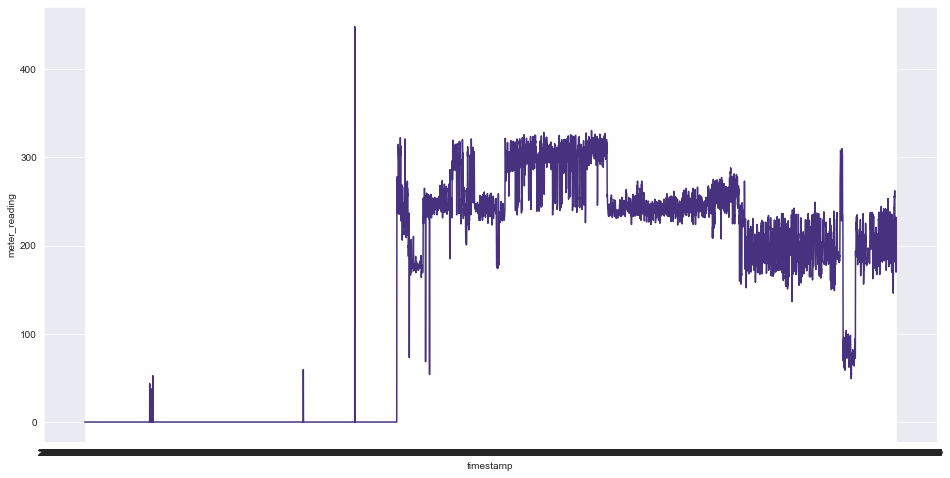

In [48]:
sns.lineplot(data=energy_build0_data,
             x='timestamp',
             y='meter_reading')

#### Объединение данных
Объединим все три фрейма в результирующий, содержащий информацию об энергопотреблении здания с индексом 0, а также его метаданные и погодные условиях, при которых производились измерения

In [10]:
# данные о зданиях + данные об энергпотреблении одного из зданий
result_data = energy_build0_data.merge(building_data,
                                       on='building_id',
                                       how='left')
result_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN


In [11]:
# данные добавились только к зданию с индексом 0
result_data[result_data.building_id > 0]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count


In [12]:
# добавим данные о погоде
result_data = result_data.merge(weather_data,
                                on=['site_id', 'timestamp'],
                                how='left')
result_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


#### Очистка данных
Наши данные содержат NaN значения, от которых желательно избавиться уже сейчас.

Для начала посмотрим на распределение NaN значений по столбцам

In [13]:
number_of_entries = len(result_data)
for column in result_data.columns:
    print('{}: {:.2f}%'.format(column,
                          (100*result_data[column].isna().sum()) / number_of_entries))

building_id: 0.00%
meter: 0.00%
timestamp: 0.00%
meter_reading: 0.00%
site_id: 0.00%
primary_use: 0.00%
square_feet: 0.00%
year_built: 0.00%
floor_count: 100.00%
air_temperature: 0.03%
cloud_coverage: 43.60%
dew_temperature: 0.03%
precip_depth_1_hr: 0.01%
sea_level_pressure: 0.97%
wind_direction: 2.85%
wind_speed: 0.00%


Для того, чтобы понимать, как **правильно** заменить NaN значения в каждом столбце, необходимо провести анализ (посмотреть на распределению этого столбца)

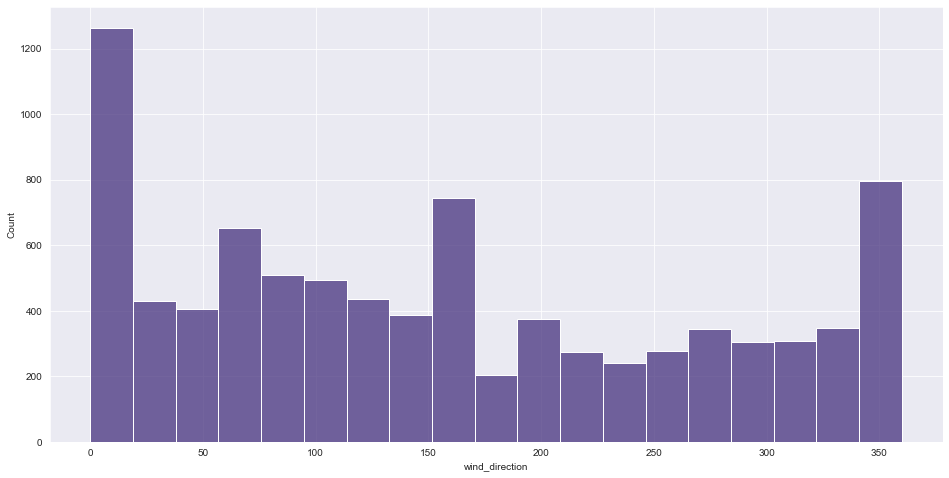

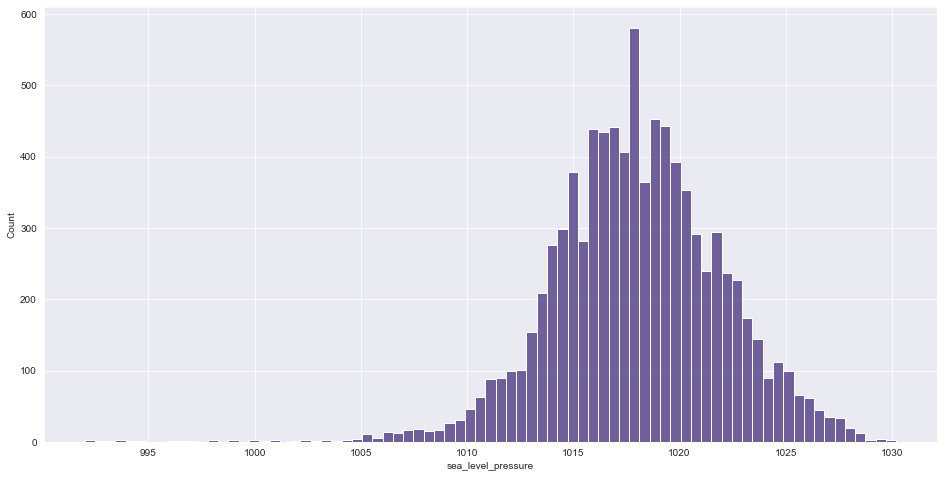

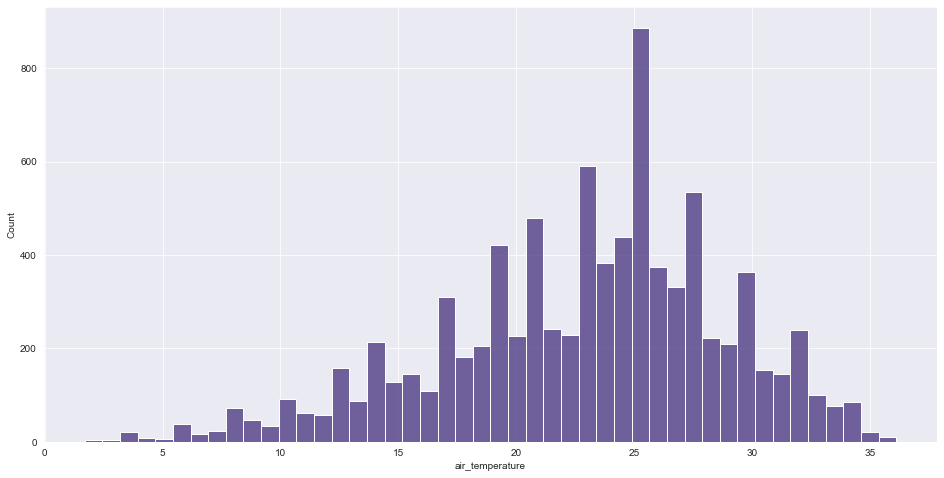

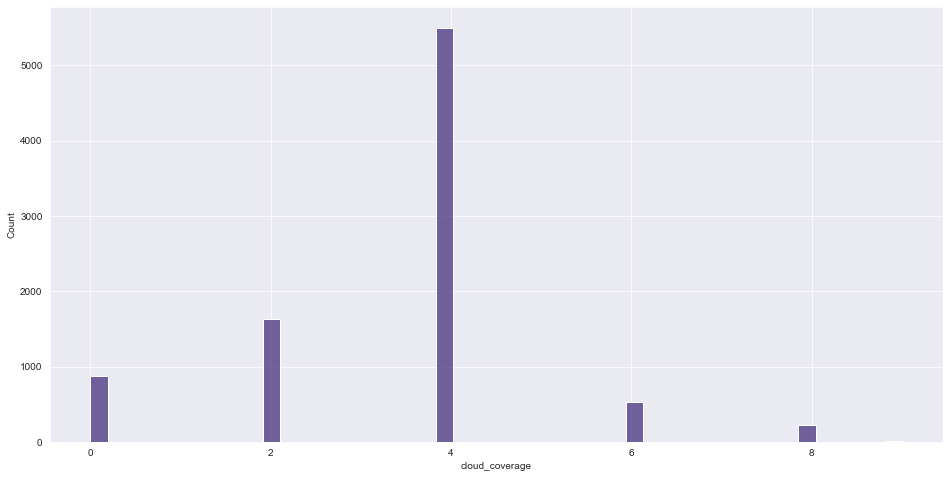

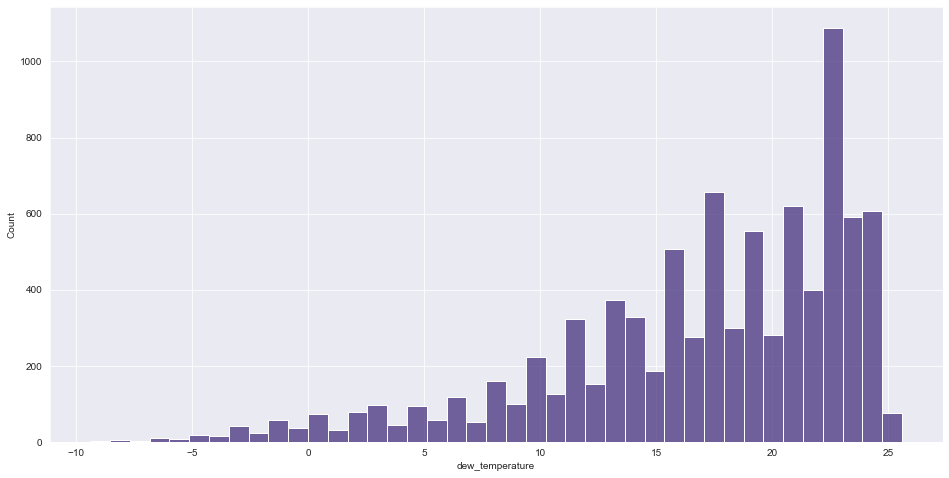

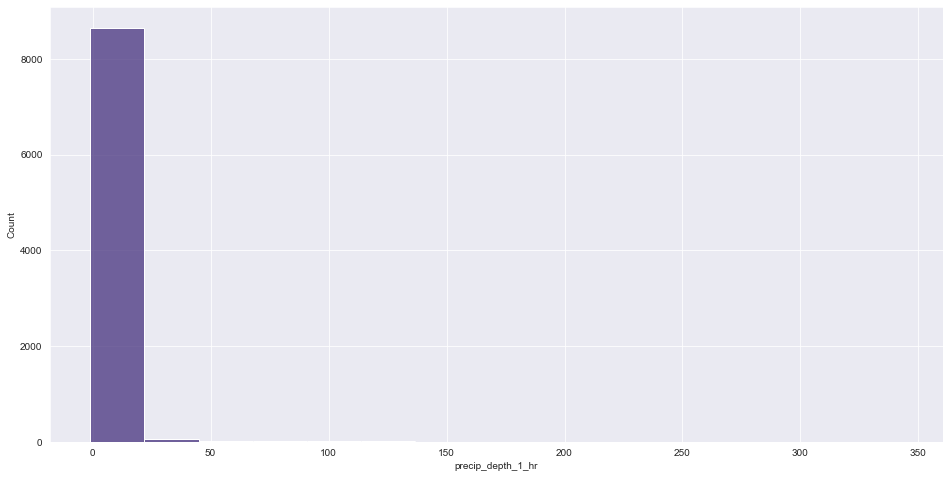

In [47]:
cols_with_NaN = ['wind_direction', 'sea_level_pressure',
                 'air_temperature', 'cloud_coverage',
                 'dew_temperature', 'precip_depth_1_hr']
for col in cols_with_NaN:
    sns.histplot(data=result_data[col])
    plt.show()

В каждой задаче проводить замену NaN значений необходимо опираясь на предметную область и данные. В текущем случае сделаем следующие преобразования:
- удалим `floor_count` (столбец не содержит никакой информации)
- `wind_direction`, `sea_level_pressure`, `air_temperature` заменим на среднее по столбцу
- `dew_temperature`, `precip_depth_1_hr`, `cloud coverage` заменим на моду по столбцу

In [14]:
result_data.drop('floor_count', axis=1, inplace=True)

In [15]:
imputer = SimpleImputer(strategy='most_frequent')
result_data[['dew_temperature', 'precip_depth_1_hr', 'cloud_coverage']] = imputer.fit_transform(result_data[['dew_temperature', 'precip_depth_1_hr', 'cloud_coverage']])

imputer = SimpleImputer(strategy='mean')
result_data[['wind_direction', 'sea_level_pressure', 'air_temperature']] = imputer.fit_transform(result_data[['wind_direction', 'sea_level_pressure', 'air_temperature']])

result_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   building_id         8784 non-null   int64  
 1   meter               8784 non-null   int64  
 2   timestamp           8784 non-null   object 
 3   meter_reading       8784 non-null   float64
 4   site_id             8784 non-null   int64  
 5   primary_use         8784 non-null   object 
 6   square_feet         8784 non-null   int64  
 7   year_built          8784 non-null   float64
 8   air_temperature     8784 non-null   float64
 9   cloud_coverage      8784 non-null   float64
 10  dew_temperature     8784 non-null   float64
 11  precip_depth_1_hr   8784 non-null   float64
 12  sea_level_pressure  8784 non-null   float64
 13  wind_direction      8784 non-null   float64
 14  wind_speed          8784 non-null   float64
dtypes: float64(9), int64(4), object(2)
memory usage: 1.1+ M

#### Экстраполяция и интерполяция
Предварительно попробуем построить модель энергпотребления в зависимости от **времени** и **даты**, не учитывая другие признаки (погодные условия и метаданные здания). Для этого обогатим наш набор данных новыми признаками

In [29]:
result_data.timestamp = pd.to_datetime(result_data.timestamp)
result_data['hour'] = result_data.timestamp.dt.hour
result_data['day'] = result_data.timestamp.dt.day
result_data['month'] = result_data.timestamp.dt.month
result_data[['month', 'day', 'hour', 'meter_reading']].sample(3)

,month,day,hour,meter_reading
3838,6,8,22,245.039
5301,8,8,21,279.850
7464,11,7,0,228.658


Посмотрим на основные статистики (медиана и среднее) по каждому месяцу/дню/часу

<AxesSubplot:xlabel='hour'>

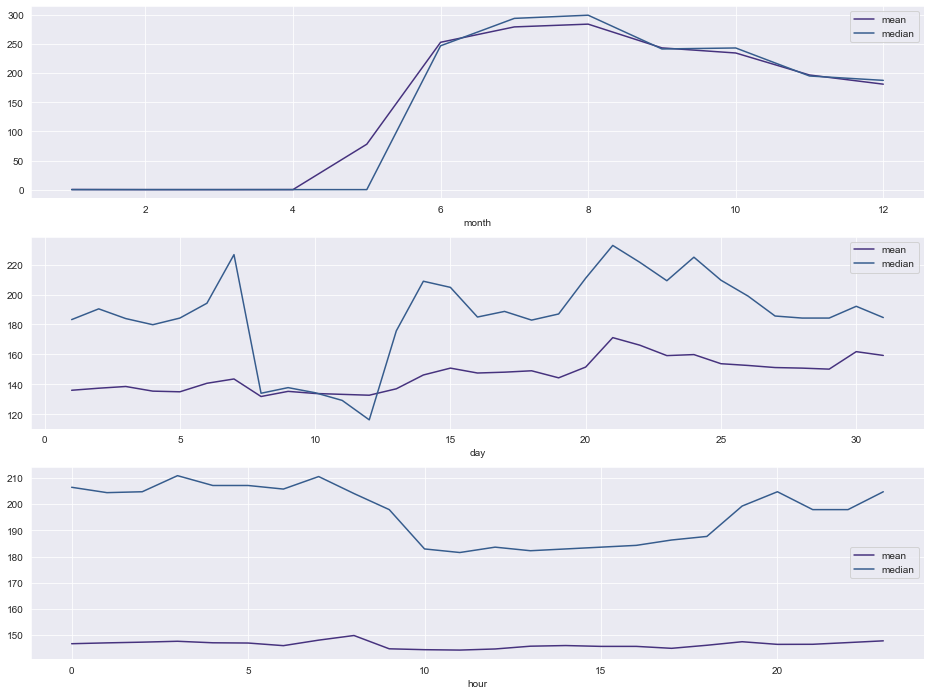

In [64]:
# группировка
month_data = result_data.groupby('month')
day_data = result_data.groupby('day')
hour_data = result_data.groupby('hour')

# визуализация
fig, ax = plt.subplots(3, 1, figsize=(16, 12))
pd.DataFrame({'mean':month_data['meter_reading'].mean(),
              'median': month_data['meter_reading'].median()}).plot(ax=ax[0])
pd.DataFrame({'mean':day_data['meter_reading'].mean(),
              'median': day_data['meter_reading'].median()}).plot(ax=ax[1])
pd.DataFrame({'mean':hour_data['meter_reading'].mean(),
              'median': hour_data['meter_reading'].median()}).plot(ax=ax[2])

Рассмотрим те же статистики после фильтрации (удалим из рассмотрения записи с нулевым энергопотреблением)

<AxesSubplot:xlabel='hour'>

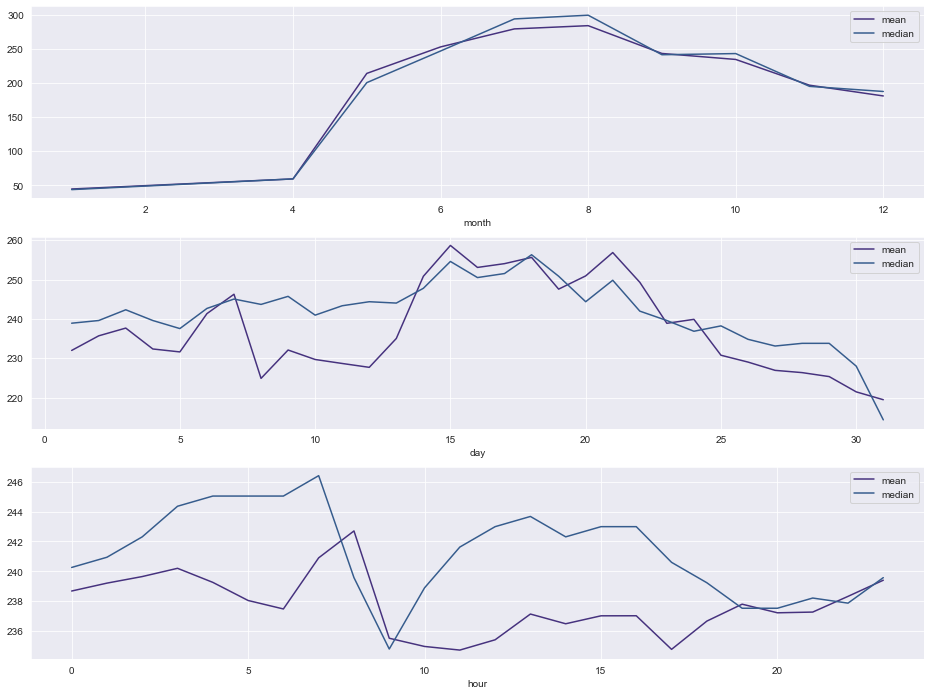

In [66]:
# группировка и фильтрация
result_data_without_zero_energy = result_data[result_data['meter_reading']>0]
month_data = result_data_without_zero_energy.groupby('month')
day_data = result_data_without_zero_energy.groupby('day')
hour_data = result_data_without_zero_energy.groupby('hour')

# визуализация
fig, ax = plt.subplots(3, 1, figsize=(16, 12))
pd.DataFrame({'mean':month_data['meter_reading'].mean(),
              'median': month_data['meter_reading'].median()}).plot(ax=ax[0])
pd.DataFrame({'mean':day_data['meter_reading'].mean(),
              'median': day_data['meter_reading'].median()}).plot(ax=ax[1])
pd.DataFrame({'mean':hour_data['meter_reading'].mean(),
              'median': hour_data['meter_reading'].median()}).plot(ax=ax[2])

Построим модель энергопотребления, ориентируясь на показатели времени и даты

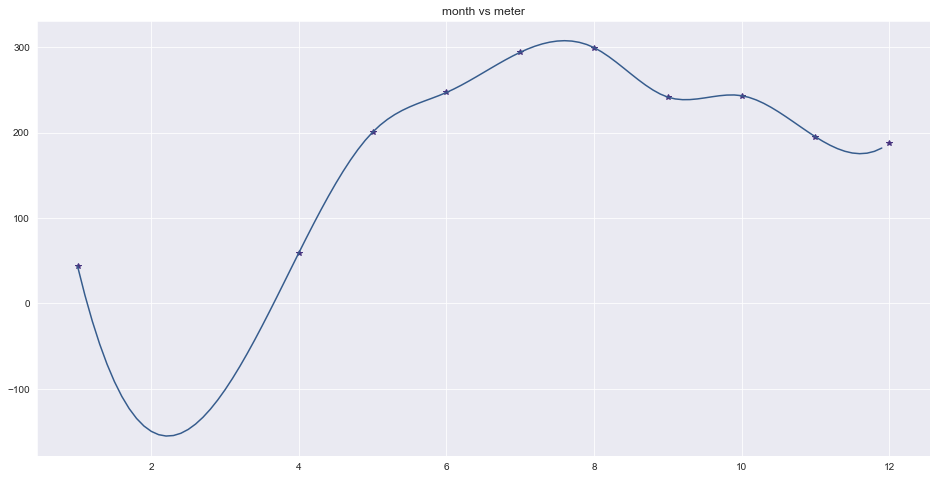

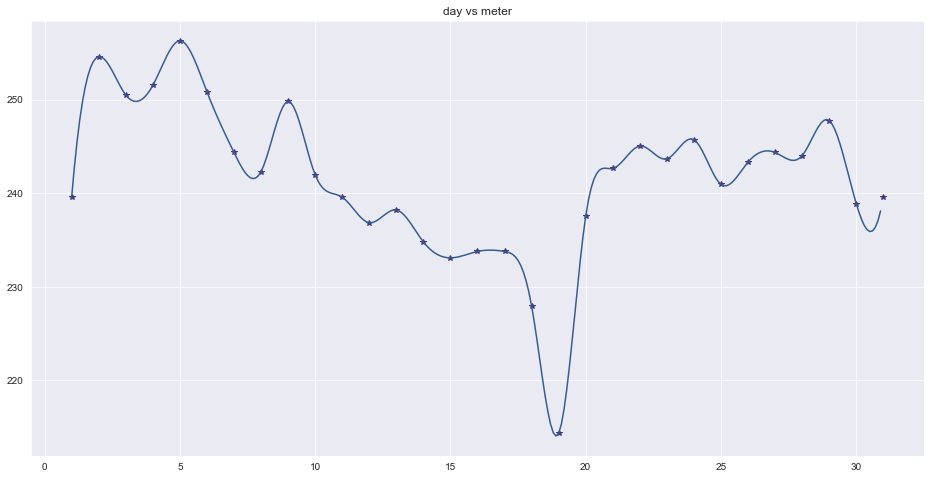

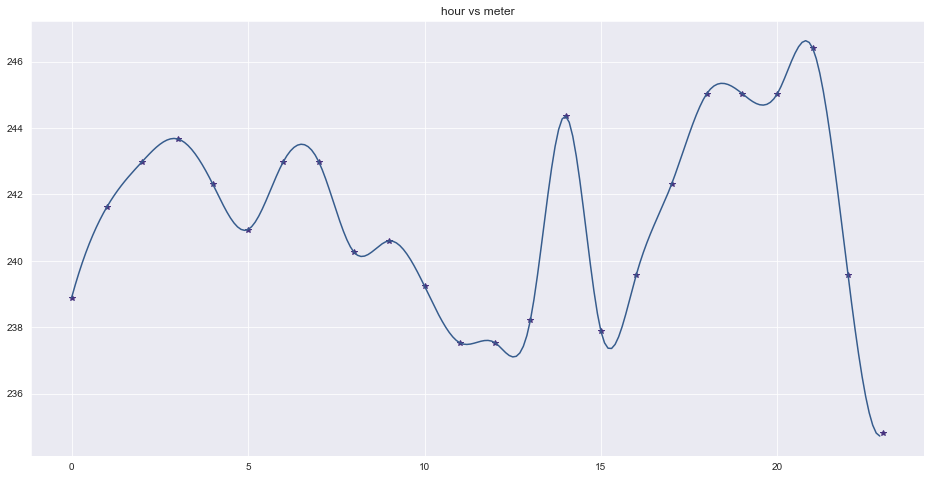

In [100]:
# оригинальные ключи
month_range = result_data_without_zero_energy.month.unique()
day_range = result_data_without_zero_energy.day.unique()
hour_range = result_data_without_zero_energy.hour.unique()

# расширенный
month_range_interpolate = np.arange(month_range.min(), month_range.max(), 0.1)
day_range_interpolate = np.arange(day_range.min(), day_range.max(), 0.1)
hour_range_interpolate = np.arange(hour_range.min(), hour_range.max(), 0.1)

# интерполяционные кривые
month_interpol = interp1d(x=month_range,
                          y=month_data['meter_reading'].median(),
                          kind='cubic')(month_range_interpolate)
day_interpol = interp1d(x=day_range,
                        y=day_data['meter_reading'].median(),
                        kind='cubic')(day_range_interpolate)
hour_interpol = interp1d(x=hour_range,
                         y=hour_data['meter_reading'].median(),
                         kind='cubic')(hour_range_interpolate)

# визуализация
plt.plot(month_range, month_data['meter_reading'].median(), '*',
                 month_range_interpolate, month_interpol, '-')
plt.title('month vs meter')
plt.show()

plt.plot(day_range, day_data['meter_reading'].median(), '*',
                 day_range_interpolate, day_interpol, '-')
plt.title('day vs meter')
plt.show()


plt.plot(hour_range, hour_data['meter_reading'].median(), '*',
                 hour_range_interpolate, hour_interpol, '-')
plt.title('hour vs meter')
plt.show()

Эта техника (интерполяция) может помочь в дальнейшем  при заполнении пропущенных значений

# EDA - Exploratory Data Analysis
Цель EDA-этапа состоит в анализе взаимосвязей между признаками (столбцами) и выявлении потенциальных особенностей данных (что может помочь при построении модели)

In [33]:
for col in result_data.columns:
    print('{} содержит {} уникальных значений'.format(col, result_data[col].nunique()))

building_id содержит 1 уникальных значений
meter содержит 1 уникальных значений
timestamp содержит 8784 уникальных значений
meter_reading содержит 330 уникальных значений
site_id содержит 1 уникальных значений
primary_use содержит 1 уникальных значений
square_feet содержит 1 уникальных значений
year_built содержит 1 уникальных значений
air_temperature содержит 75 уникальных значений
cloud_coverage содержит 6 уникальных значений
dew_temperature содержит 73 уникальных значений
precip_depth_1_hr содержит 71 уникальных значений
sea_level_pressure содержит 274 уникальных значений
wind_direction содержит 38 уникальных значений
wind_speed содержит 28 уникальных значений


Отсечем признаки, содержащие **одно** уникальное значение. Причина: они не информативны для построения модели

In [34]:
result_data.drop(['site_id', 'primary_use', 'square_feet',
                  'year_built', 'meter', 'building_id'], axis=1, inplace=True)
result_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,0.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,2016-01-01 01:00:00,0.0,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5
2,2016-01-01 02:00:00,0.0,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,2016-01-01 03:00:00,0.0,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,2016-01-01 04:00:00,0.0,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


Заметим, что число уникальных значений в `timestamp` совпадает с числом строк в нашем фрейме: это вполне логично, ведь данных собирались в разные промежутке времени. В связи с этим, установим Time Series в качестве индекса

In [36]:
len(result_data) == result_data['timestamp'].nunique()

True

In [37]:
result_data.set_index('timestamp', inplace=True)
result_data.head(3)

,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,0.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
2016-01-01 01:00:00,0.0,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5
2016-01-01 02:00:00,0.0,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


Далее посмотрим на распределения наших признаков. В зависимости от количества уникальных значений можно использовать разные графики.

<AxesSubplot:xlabel='cloud_coverage', ylabel='count'>

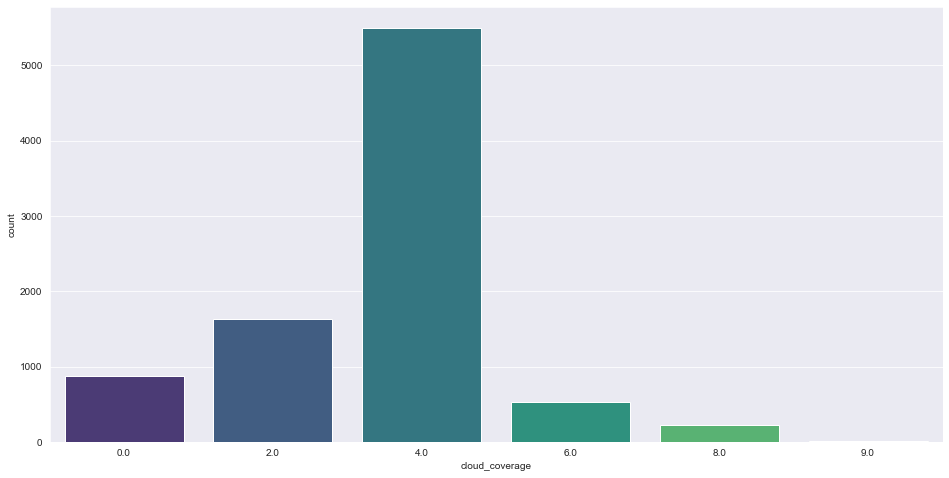

In [45]:
sns.countplot(data=result_data, x='cloud_coverage')

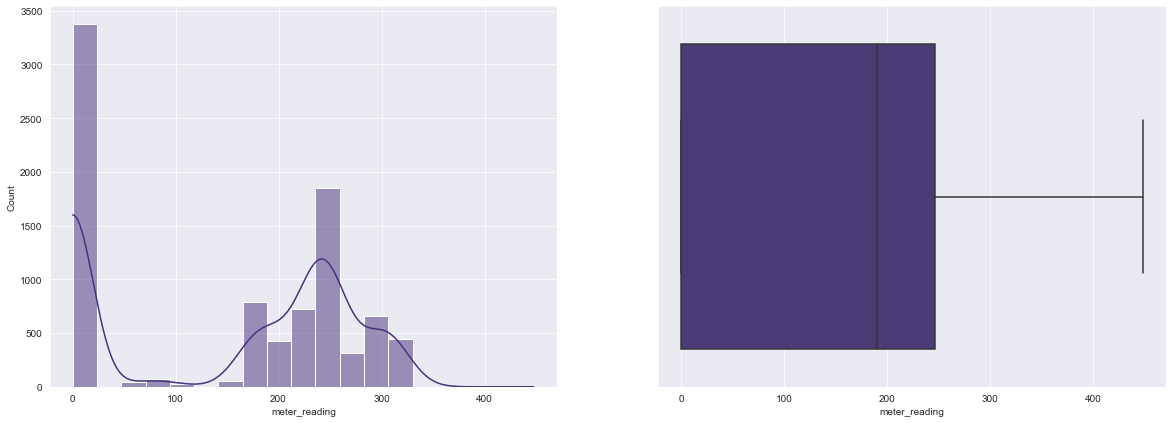

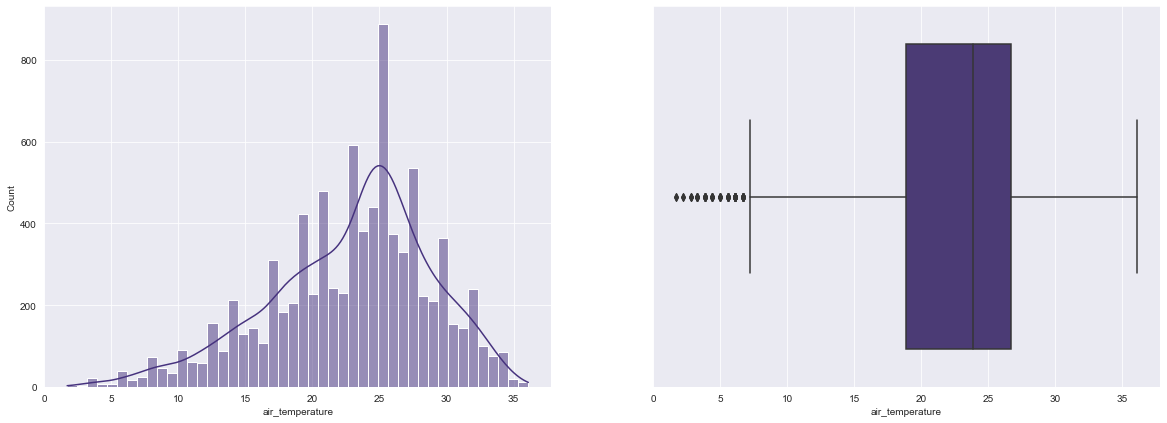

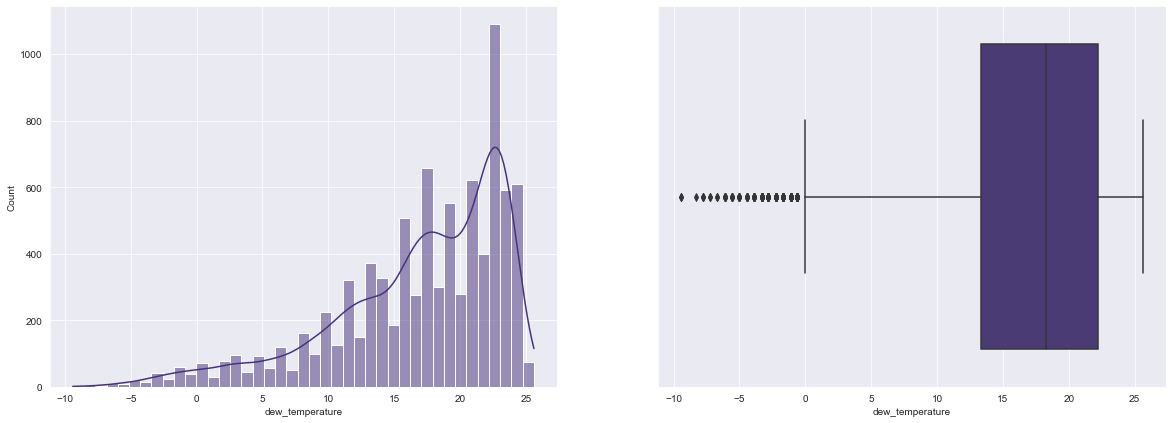

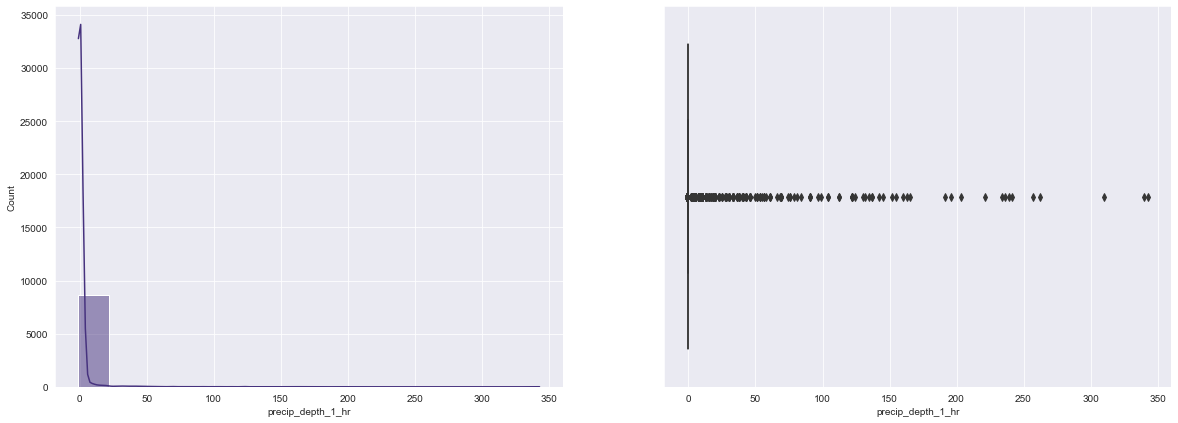

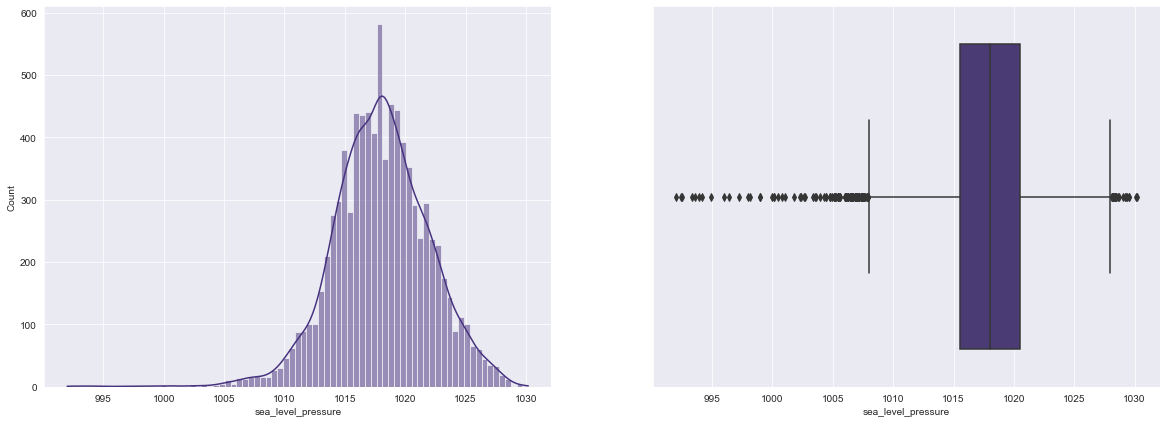

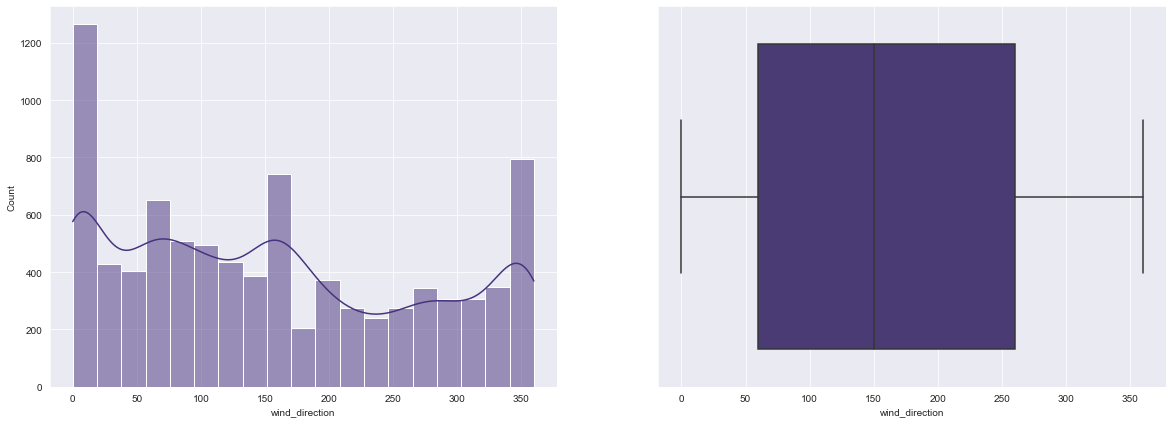

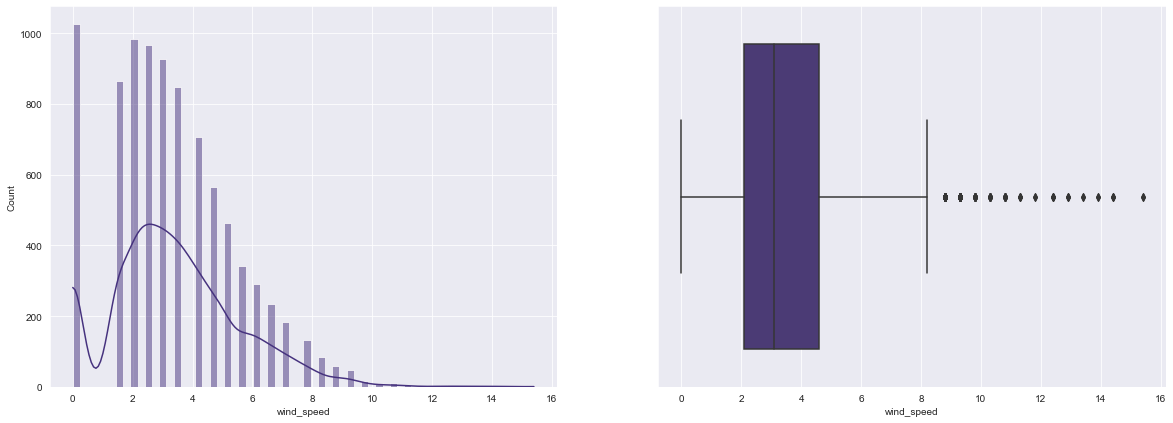

In [46]:
for col in ['meter_reading', 'air_temperature', 'dew_temperature',
           'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
           'wind_speed']:
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    sns.histplot(data=result_data, x=col, ax=ax[0], kde=True)
    sns.boxplot(data=result_data, x=col, ax=ax[1])
    
    plt.show()